In [1]:
#!pip install -r requirements.txt --user
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from datetime import datetime
import math
import unicodedata
from unicodedata import normalize
import re
from dateutil.relativedelta import relativedelta
import pingouin
import sklearn
#from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import scipy
from scipy.stats import chi2_contingency

## 0.0 Arreglando las rutas ##

In [2]:
ruta_madre="C:/Users/USUARIO/Documents/GitHub/Team_224/Proyecto"
ruta_insumos=os.path.join(ruta_madre, 'Insumos')
ruta_resultados=os.path.join(ruta_madre, 'Resultados')

## 1.0 IMPORTANDO LA DATA ##


### 1.1 Importando sueldos (info_nomina)


In [3]:
os.chdir(os.path.join(ruta_insumos,'Descripcion_empleados'))
sendero_sueldos=os.path.join(os.getcwd(),'Sueldos_nomina_consolidados.csv')
sueldos=pd.read_csv(sendero_sueldos,sep=";")
#sueldos['year']=sueldos['year'].astype('float64')
sueldos['Codigo']=sueldos['Codigo'].astype('int').astype('str')
sueldos.drop_duplicates(['year','Codigo','Nombres'],inplace=True)

### 1.3 Importando datos demograficos (perfil_socidemografico)

In [4]:
os.chdir(os.path.join(ruta_insumos,"Encuesta_sociodem_empleados"))
sendero_feature=os.path.join(os.getcwd(),str(os.listdir()[0]))
feature_demo=pd.read_excel(sendero_feature)
#feature_demo.dropna(subset=["NOMBRE_CLAVE"],inplace=True)

#estadisticos_iniciales=consol_data.describe(include = ['O'])


### 1.4 Importando datos de actividades de solicitudes (detalle_tramites)

In [5]:
os.chdir(os.path.join(ruta_insumos,'Datos_eventos'))
sendero_eventos=os.path.join(os.getcwd(),str(os.listdir()[0]))
datos_eventos=pd.read_excel(sendero_eventos)
datos_eventos['cedula']=datos_eventos['cedula'].astype('str')
#datos_eventos.dropna(subset=["NOMBRE_CLAVE"],inplace=True)


## 2.0 LIMPIANDO LA DATA Y PRIOR FEATURE ENGINEERING ##

In [6]:

feature_demo['NUMERO_DE_DOCUMENTO']=feature_demo.NUMERO_DE_DOCUMENTO.astype('int').astype('str').str.strip()
sueldos['Codigo']=sueldos['Codigo'].str.strip()
consol_data_con_features=datos_eventos.merge(feature_demo,how='left',right_on='NUMERO_DE_DOCUMENTO',left_on='cedula')

data_agregada=consol_data_con_features.merge(sueldos[['year','Codigo','Sueldo','Cargo']],how='left',left_on=['year','cedula'],right_on=['year','Codigo'])


### 2.1 creando la edad y años de experiencia

In [7]:
data_agregada['fecha_analisis']=[pd.to_datetime(datetime(data_agregada['year'][x],data_agregada['MES'][x],1)) for x in range(len(data_agregada['year']))]

years_born=data_agregada['fecha_analisis']-data_agregada['FECHA_DE_NACIMIENTO']

data_agregada['edad']=years_born.dt.days//360; del years_born

expertise=data_agregada['fecha_analisis']-data_agregada['FECHA_DE_INGRESO']
data_agregada['years_antiguedad']=expertise.dt.days/360 ; del expertise

data_agregada.drop(columns=['NOMBRES','APELLIDOS','Codigo','NUMERO_DE_DOCUMENTO'],inplace=True)


### 2.2 Arreglando variable 'MUNICIPIO_DE_RESIDENCIA'

In [8]:
data_agregada['MUNICIPIO_DE_RESIDENCIA']=data_agregada.MUNICIPIO_DE_RESIDENCIA.str.lower().str.strip().str.replace('[ ]+','_')

def normalizar(x):
    
    caracter_norm=re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", x
            ), 0, re.I
        )
    return caracter_norm

prueba=[]
for i in range(len(data_agregada['MUNICIPIO_DE_RESIDENCIA'])):
    
    try:
        prueba.append(normalizar(data_agregada['MUNICIPIO_DE_RESIDENCIA'][i]))
    except:
        
        prueba.append(np.nan)
    
    
data_agregada['MUNICIPIO_DE_RESIDENCIA']=prueba

C:\Users\USUARIO\AppData\Local\Temp/ipykernel_12856/1830578000.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_agregada['MUNICIPIO_DE_RESIDENCIA']=data_agregada.MUNICIPIO_DE_RESIDENCIA.str.lower().str.strip().str.replace('[ ]+','_')


### 2.3 Normalizando y estandarizando solicitudes

In [9]:
## que quede solicitudes, autorizaciones por dia para evitar el sesgo por mayores dias en un mes

data_agregada['fecha_fin']=pd.to_datetime([data_agregada['fecha_analisis'][j]+relativedelta(months=1) for j in range(len(data_agregada['fecha_analisis']))])
data_agregada['dias_mes']=data_agregada['fecha_fin']-data_agregada['fecha_analisis']
data_agregada['dias_mes']=data_agregada['dias_mes'].dt.days
data_agregada['solicitudes_per_day']=data_agregada['Solicitud']/data_agregada['dias_mes']
data_agregada['autorizaciones_per_day']=data_agregada['Autorizacion']/data_agregada['dias_mes']
data_agregada['codigos_per_day']=data_agregada['codigo']/data_agregada['dias_mes']



### 2.4 Normalizando arreglando variable 'PROFESION'

In [10]:
data_agregada['PROFESION']=data_agregada['PROFESION'].str.lower()

prueba=[]
for i in range(len(data_agregada['PROFESION'])):
    
    try:
        prueba.append(normalizar(data_agregada['PROFESION'][i]))
    except:
        
        prueba.append(np.nan)
   
    
data_agregada['PROFESION']=prueba

profesiones={'administracion de empresas':'admin_empresas',
             'administrador en servicios de la salud':'admin_servicios_salud',
             'secretaria':'secretariado',
             'asistente administrativo':'asistente_administrativo',
             'tecnico en auxiliar de enfermeria':'auxiliar_enfermeria',
             'auxiliar de enfermeria':'auxiliar_enfermeria',
             'tecnico auxiliar de enfermera':'auxiliar_enfermeria',
             'tecnico auxiliar de enfemeria':'auxiliar_enfermeria',
             'tecnico en agente  call center':'agente_call_center',
             'tecnico agente de contact center':'agente_call_center',
             'administrador en salud':'admin_servicios_salud',
             'administracion en salud':'admin_servicios_salud',
             'administrador de empresas':'admin_empresas',
             'tecnico en asistencia administrativa':'asistente_administrativo'
             }

data_agregada['PROFESION']=data_agregada['PROFESION'].replace(profesiones)


### 2.4 Normalizando arreglando variable 'PROFESION'

In [11]:
prueba=[]
for i in range(len(data_agregada['NIVEL_DE_ESCOLARIDAD'])):
    
    try:
        prueba.append(normalizar(data_agregada['NIVEL_DE_ESCOLARIDAD'][i]))
    except:
        
        prueba.append(np.nan)
   
  
data_agregada['NIVEL_DE_ESCOLARIDAD']=prueba


## 3.0 Exploratory Data Analysis ##

Información general de la tasa  consolidada. donde preferimos cambiarle los nombres a cada variable.

In [12]:
data_agregada.DOCUMENTO_DE_IDENTIFICACION

0       CÉDULA DE CIUDADANÍA
1       CÉDULA DE CIUDADANÍA
2       CÉDULA DE CIUDADANÍA
3       CÉDULA DE CIUDADANÍA
4       CÉDULA DE CIUDADANÍA
                ...         
1678    CÉDULA DE CIUDADANÍA
1679    CÉDULA DE CIUDADANÍA
1680    CÉDULA DE CIUDADANÍA
1681    CÉDULA DE CIUDADANÍA
1682    CÉDULA DE CIUDADANÍA
Name: DOCUMENTO_DE_IDENTIFICACION, Length: 1683, dtype: object

In [13]:
data_agregada.columns=['year','month','promoter_name','cedula','request_number','autorization','code','type_id','gender','birth_date','place_birth','is_special_population','any_disability','MUNICIPIO_DE_RESIDENCIA','ZONA','home_type','education_level','PROFESION','start_job_date','job_position','experience','work_background','CENTRO_DE_TRABAJO','contract_type','marital_status','children_amount','other_on_charge_person','ESTRATO_SOCIAL','wage','Position','analyzed_date','age','years_exp_current_role','fecha_fin','dias_mes','request_attend_per_day','autorizations_per_day',
                       'codes_per_day']

In [14]:
data_agregada.columns

Index(['year', 'month', 'promoter_name', 'cedula', 'request_number',
       'autorization', 'code', 'type_id', 'gender', 'birth_date',
       'place_birth', 'is_special_population', 'any_disability',
       'MUNICIPIO_DE_RESIDENCIA', 'ZONA', 'home_type', 'education_level',
       'PROFESION', 'start_job_date', 'job_position', 'experience',
       'work_background', 'CENTRO_DE_TRABAJO', 'contract_type',
       'marital_status', 'children_amount', 'other_on_charge_person',
       'ESTRATO_SOCIAL', 'wage', 'Position', 'analyzed_date', 'age',
       'years_exp_current_role', 'fecha_fin', 'dias_mes',
       'request_attend_per_day', 'autorizations_per_day', 'codes_per_day'],
      dtype='object')

In [15]:
data_agregada.info() ## la variables provenientes de los sueldos año a año, tienen cerca del 56% de la data dañada por falta de info de sueldos en ciertos años, 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   year                     1683 non-null   int64         
 1   month                    1683 non-null   int64         
 2   promoter_name            1683 non-null   object        
 3   cedula                   1683 non-null   object        
 4   request_number           1683 non-null   int64         
 5   autorization             1683 non-null   int64         
 6   code                     1683 non-null   int64         
 7   type_id                  1680 non-null   object        
 8   gender                   1680 non-null   object        
 9   birth_date               1680 non-null   datetime64[ns]
 10  place_birth              1680 non-null   object        
 11  is_special_population    1680 non-null   object        
 12  any_disability           1680 non-

In [16]:
diccion_gender={'MASCULINO':'MALE',
               'FEMENINO':'FEMALE'}
data_agregada.gender.replace(diccion_gender,inplace=True)

In [17]:
## describe las variables numericas y categoricas
data_agg_describe_numeric=data_agregada.describe()
data_agg_describe_object=data_agregada.describe(include=['O'])
data_agg_describe_object

,promoter_name,cedula,type_id,gender,place_birth,is_special_population,any_disability,MUNICIPIO_DE_RESIDENCIA,ZONA,home_type,education_level,PROFESION,job_position,experience,work_background,CENTRO_DE_TRABAJO,contract_type,marital_status,Position
count,1683,1683,1680,1680,1680,1680,1680,1680,1680,1680,1680,1618,1680,1290,1290,1680,1680,1680,957
unique,45,45,1,2,21,5,1,8,2,3,3,10,7,27,5,8,1,4,3
top,ROSY MUÑOZ,30574770,CÉDULA DE CIUDADANÍA,FEMALE,Montería,NO APLICA,NO,monteria,URBANA,ARRENDADA,TECNICO,admin_servicios_salud,GESTOR DE SALUD,8 AÑOS,SERVICIO AL CLIENTE,MAGISTERIO,TÉRMINO INDEFINIDO,SINGLE,AUXILIAR CITAS
freq,95,95,1680,1413,575,1371,1680,1069,1639,816,928,582,955,152,863,604,1680,991,610


### 3.1 Correlación de las variables

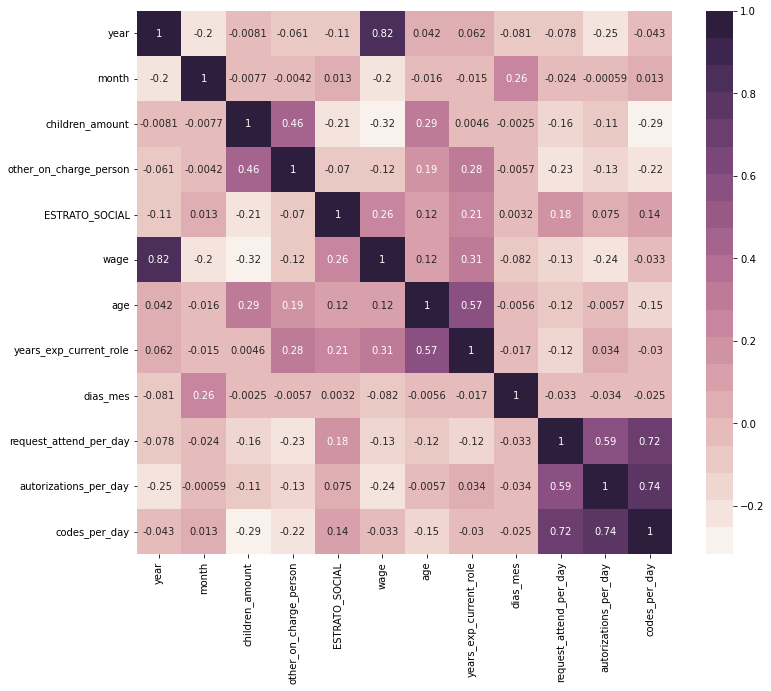

In [18]:
plt.figure(figsize=(12,10))
corr = data_agregada[['year','month','children_amount', 'other_on_charge_person','ESTRATO_SOCIAL', 'wage','age','years_exp_current_role', 'dias_mes','request_attend_per_day', 'autorizations_per_day', 'codes_per_day']].corr()
ax=sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
ax.xaxis.tick_top
plt.show()

### 3.2 Producto por promotor y por año

<AxesSubplot:xlabel='year', ylabel='prod_per_capita'>

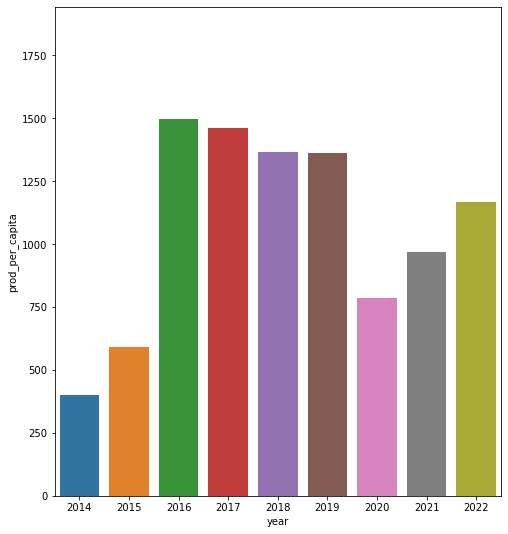

In [19]:
## graficas de visualizacion

plt.figure(figsize=(8,9))

## solicitud atendidas por year
sns.lineplot(x='year',y='request_number',data=data_agregada)


## solicitudes per capita atendias por year
suma_solicitudes=data_agregada.groupby('year').agg({'request_number': 'sum', 'promoter_name': 'count'}).reset_index()
suma_solicitudes['prod_per_capita']=suma_solicitudes.request_number/suma_solicitudes.promoter_name
sns.barplot(x='year',y='prod_per_capita',data=suma_solicitudes)


### Análisis

Se presentaton mayor número de solicitudes en el año 2016 y 2017, se ha venido disminuyendo con la puntuación más 
baja en el 2020 esto se puede deber a impacto al COVID - 19

La cantidad de solicitudes atendidas por Gestores de citas tiene un comportamiento similar al número de número de
solicitudes, se presenta un incremento en el año 2016 y 2017.



<AxesSubplot:xlabel='year', ylabel='prod_per_capita'>

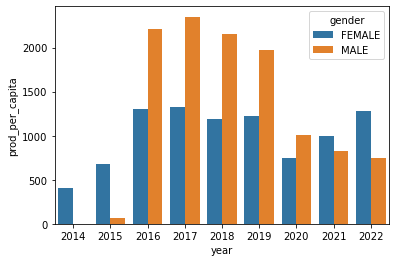

In [20]:
## solicitudes per capita atendias por genero
suma_solicitudes_Genero =data_agregada.groupby(['year','gender']).agg({'request_number': 'sum', 'promoter_name': 'count'}).reset_index()
suma_solicitudes_Genero['prod_per_capita']=suma_solicitudes_Genero.request_number/suma_solicitudes_Genero.promoter_name
sns.barplot(x='year',y='prod_per_capita',hue='gender',data=suma_solicitudes_Genero)


### Análisis

En general se observa que la atención de solicitudes presentan un mayor rendimiento en los hombres en
comparación con las mujeres.
Por otro lado, al parecer las mujeres tecnologas lo hacen mejor, mientras que los hombres profesionales lo hacen mejor. aunque hay que mencionar que podemos tener patrones escondidos. del mismo modo al realizar una prueba de diferencia de medias, se observa queefectivamente las solicitudes por dia de los hombres es mas grand que el de las mujeres
sin embargo, debido al sesgo de la medida, es posible que la prueba pueda dar resultados no tan creibles


In [37]:
data_agregada.drop_duplicates(subset=['promoter_name'])

ROSY MUÑOZ                              1
SOLANDY MARIA FERNANDEZ FERNANDEZ       1
JESSICA ROMERO                          1
KENYA LUCIA MARTINEZ NARVAEZ            1
DIANA CECILIA RAMIREZ VILLEGAS          1
YAMELIS DEL CARMEN BALLESTA VILLALBA    1
ORCELYS LAUDITH OROZCO GUERRA           1
LINDA MARIA VILLADIEGO GUILLEN          1
NATALIA PEREZ NIETO                     1
YERALDIN YAMITH LOBO VILLEGAS           1
KERLY JOHANA ORTEGA PINTO               1
LUIS DIEGO VERGARA VILLAR               1
MARIA JOSE MUÑOZ CARREÑO                1
YEIMI JOHANA BARRERA VARILLA            1
CAROLINA HOYOS VELASQUEZ                1
DALIA INES ROMERO MOYA                  1
NORBERTO HERNANDEZ RHENALS              1
ORIANA NATALY RUIZ GALLEGO              1
CLARA YULIETH DIAZ GONZALES             1
SEBASTIAN RUIZ OVIEDO                   1
DARY LUZ LOZANO ANAYA                   1
LESLIE LUZ OSORIO HERRERA               1
ANA GREY ARRIETA                        1
VILMA PADILLA                     

In [30]:
data_agregada

,year,month,promoter_name,cedula,request_number,autorization,code,type_id,gender,birth_date,...,wage,Position,analyzed_date,age,years_exp_current_role,fecha_fin,dias_mes,request_attend_per_day,autorizations_per_day,codes_per_day
0,2014,6,ROSY MUÑOZ,30574770,228,224,62,CÉDULA DE CIUDADANÍA,FEMALE,1975-10-19,...,NaN,NaN,2014-06-01,39.0,7.691667,2014-07-01,30,7.600000,7.466667,2.066667
1,2014,6,VILMA PADILLA,39144315,108,106,58,CÉDULA DE CIUDADANÍA,FEMALE,1983-11-03,...,NaN,NaN,2014-06-01,31.0,2.577778,2014-07-01,30,3.600000,3.533333,1.933333
2,2014,7,ROSY MUÑOZ,30574770,414,415,85,CÉDULA DE CIUDADANÍA,FEMALE,1975-10-19,...,NaN,NaN,2014-07-01,39.0,7.775000,2014-08-01,31,13.354839,13.387097,2.741935
3,2014,7,VILMA PADILLA,39144315,108,98,70,CÉDULA DE CIUDADANÍA,FEMALE,1983-11-03,...,NaN,NaN,2014-07-01,31.0,2.661111,2014-08-01,31,3.483871,3.161290,2.258065
4,2014,8,ROSY MUÑOZ,30574770,338,339,64,CÉDULA DE CIUDADANÍA,FEMALE,1975-10-19,...,NaN,NaN,2014-08-01,39.0,7.861111,2014-09-01,31,10.903226,10.935484,2.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,2022,4,YEIMI JOHANA BARRERA VARILLA,1067941858,375,125,189,CÉDULA DE CIUDADANÍA,FEMALE,1995-06-16,...,1060000.0,GESTOR DE SALUD,2022-04-01,27.0,1.080556,2022-05-01,30,12.500000,4.166667,6.300000
1679,2022,4,YERALDIN YAMITH LOBO VILLEGAS,1067921481,4918,1,6,CÉDULA DE CIUDADANÍA,FEMALE,1993-02-25,...,1060000.0,GESTOR DE SALUD,2022-04-01,29.0,4.730556,2022-05-01,30,163.933333,0.033333,0.200000
1680,2022,4,YESSIKA PAOLA GONZALEZ RAMOS,1069479384,248,1,136,CÉDULA DE CIUDADANÍA,FEMALE,1989-08-02,...,NaN,NaN,2022-04-01,33.0,10.394444,2022-05-01,30,8.266667,0.033333,4.533333
1681,2022,4,YULIETH PAOLA DURANGO COGOLLO,1003713362,923,17,147,CÉDULA DE CIUDADANÍA,FEMALE,2000-12-30,...,NaN,NaN,2022-04-01,21.0,2.958333,2022-05-01,30,30.766667,0.566667,4.900000


<AxesSubplot:xlabel='gender', ylabel='request_attend_per_day'>

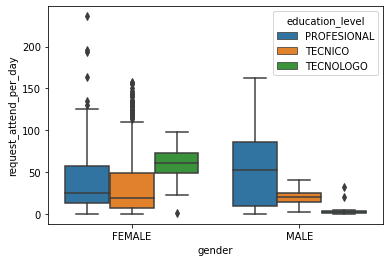

In [39]:
sns.boxplot(x='gender',y='request_attend_per_day',hue='education_level',data=data_agregada)
#sns.boxplot(x='gender',y='request_attend_per_day',hue='education_level',data=data_agregada.drop_duplicates(subset=['promoter_name']))

<AxesSubplot:xlabel='gender', ylabel='request_attend_per_day'>

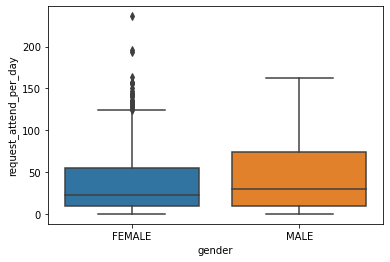

In [39]:
sns.boxplot(x='gender',y='request_attend_per_day',data=data_agregada)


In [40]:
data_agregada.drop_duplicates(subset=['promoter_name']).groupby('gender')['education_level'].value_counts().to_frame()

education_level
gender education_level                 
FEMALE TECNICO                       20
       PROFESIONAL                   15
       TECNOLOGO                      1
MALE   PROFESIONAL                    6
       TECNICO                        1
       TECNOLOGO                      1

In [45]:
pingouin.ttest(data_agregada[data_agregada.gender=='MALE']['request_attend_per_day'], data_agregada[data_agregada.gender=='FEMALE']['request_attend_per_day'],alternative='greater')

#pingouin.ttest(data_agregada.drop_duplicates(subset=['promoter_name'])[data_agregada.gender=='MALE']['request_attend_per_day'], data_agregada.drop_duplicates(subset=['promoter_name'])[data_agregada.gender=='FEMALE']['request_attend_per_day'],alternative='greater')
#data_agregada.drop_duplicates(subset=['promoter_name'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.988986,330.910817,greater,0.000041,"[6.32, inf]",0.31317,362.722,0.998841


<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

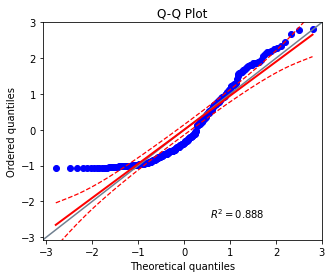

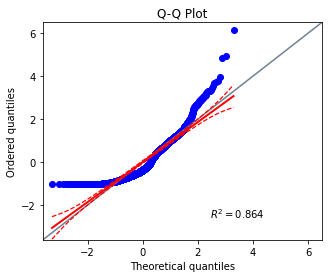

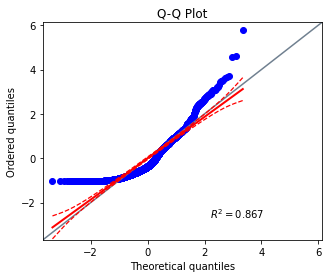

In [47]:
pingouin.qqplot(data_agregada[data_agregada.gender=='MALE']['request_attend_per_day'],'norm')
pingouin.qqplot(data_agregada[data_agregada.gender=='FEMALE']['request_attend_per_day'],'norm')
pingouin.qqplot(data_agregada['request_attend_per_day'],'norm')


## Análisis

Notará que aunque la historia general muestra un mejor desempeño de los hombres, si se segmenta por 
año se puede ver que esto no sucede en los últimos años y que la tendencia se devuelve




<AxesSubplot:xlabel='year', ylabel='request_attend_per_day'>

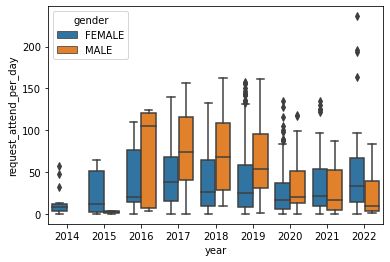

In [49]:
sns.boxplot(hue='gender',x='year',y='request_attend_per_day',data=data_agregada)

### Análisis

En general se observa que la atención de solicitudes presentan un mayor rendimiento en los hombres en comparación con las mujeres.


<AxesSubplot:xlabel='age', ylabel='prod_per_capita'>

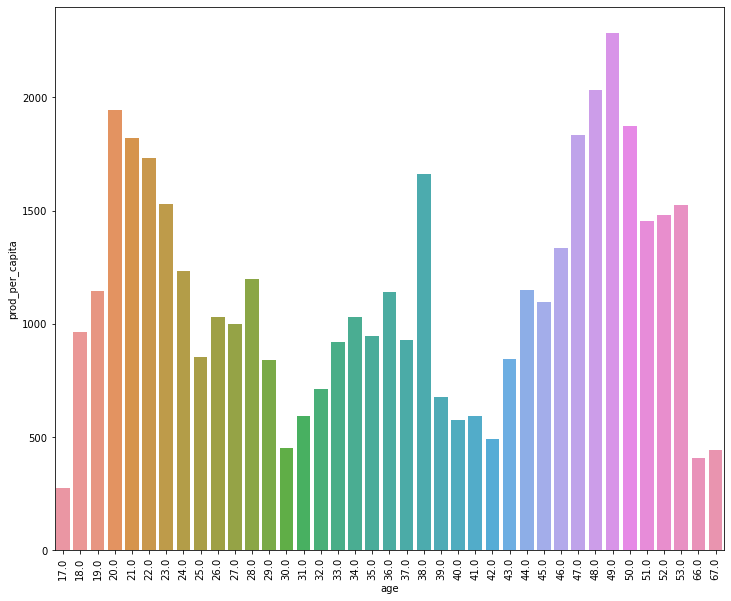

In [52]:
## solicitudes per capita atendias por edad
plt.figure(figsize=(12,10))
suma_solicitudes_Edad =data_agregada.groupby(['age']).agg({'request_number': 'sum', 'promoter_name': 'count'}).reset_index()
suma_solicitudes_Edad['prod_per_capita']=suma_solicitudes_Edad.request_number/suma_solicitudes_Edad.promoter_name
plt.xticks(rotation=90)
sns.barplot(x='age',y='prod_per_capita',data=suma_solicitudes_Edad)


<AxesSubplot:xlabel='years_exp_current_role', ylabel='request_attend_per_day'>

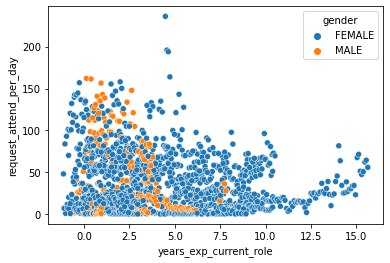

In [54]:
sns.scatterplot(x='years_exp_current_role',y='request_attend_per_day',hue='gender',data=data_agregada)

<AxesSubplot:xlabel='age', ylabel='request_attend_per_day'>

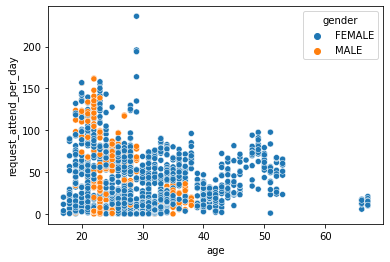

In [55]:

#plt.title('años de antiguedad vs solicitudes por dia')
sns.scatterplot(x='age',y='request_attend_per_day',hue='gender',data=data_agregada)


### Análisis

Aunque el ESTADO CIVIL dice que las persones en union libres tienden a ser menos aptas para procesar autorizaciones, lo que si se 
observa es que hay una relacion cuadratica de personas a cargo hay una relacion cuadratica negativa con punto de inflexión en 3 personas


<AxesSubplot:xlabel='marital_status', ylabel='request_attend_per_day'>

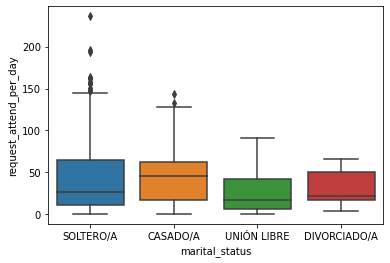

In [56]:

sns.boxplot(x='marital_status',y='request_attend_per_day',data=data_agregada)

<AxesSubplot:xlabel='ESTRATO_SOCIAL', ylabel='request_attend_per_day'>

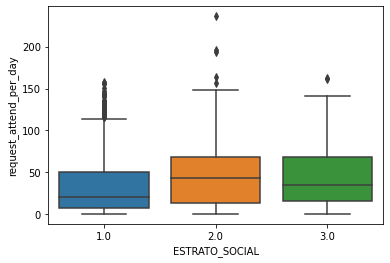

In [57]:
sns.boxplot(x='ESTRATO_SOCIAL',y='request_attend_per_day',data=data_agregada)

<AxesSubplot:xlabel='other_on_charge_person', ylabel='request_attend_per_day'>

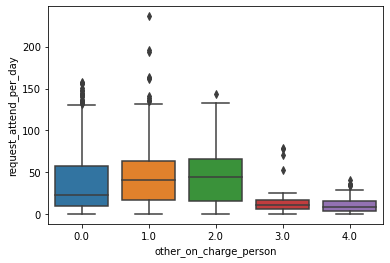

In [58]:
sns.boxplot(x='other_on_charge_person',y='request_attend_per_day',data=data_agregada)

<AxesSubplot:xlabel='home_type', ylabel='request_attend_per_day'>

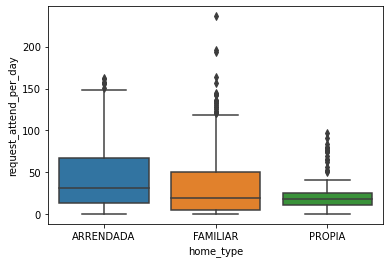

In [59]:
sns.boxplot(x='home_type',y='request_attend_per_day',data=data_agregada)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'MAGISTERIO'),
  Text(1, 0, 'ALMERÍA'),
  Text(2, 0, 'SAHAGÚN'),
  Text(3, 0, 'MONTELÍBANO'),
  Text(4, 0, 'PLANETA RICA'),
  Text(5, 0, 'ADMINISTRACIÓN'),
  Text(6, 0, 'VERSALLES'),
  Text(7, 0, 'NUEVA EPS')])

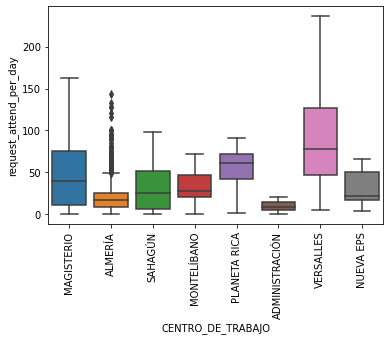

In [61]:

sns.boxplot(x='CENTRO_DE_TRABAJO',y='request_attend_per_day',data=data_agregada)
plt.xticks(rotation=90)

## Análisis

En general se observa que la atención de solicitudes presentan un mayor rendimiento en los hombres entre 
el año 2016 y el 2020 en comparación con las mujeres. Sin embargo, se observa un incremento apartir del año 2021 
y en lo que va corriendo del 2022.



### Análisis

Las personas con mayor nivel educativo que se encuentran en este cargo, viven en arriendo en su mayoria. puede ser que
los altos niveles de endeudamiento por recurrir a un profesional y una remuneracion estandar, no les permita tener vivienda propia


In [45]:
prof_tipovi=pd.crosstab(data_agregada.drop_duplicates(subset=['promoter_name'])['education_level'],data_agregada.drop_duplicates(subset=['promoter_name'])['home_type'])
prof_tipovi

home_type,ARRENDADA,FAMILIAR,PROPIA
education_level,,,
PROFESIONAL,13,6,2
TECNICO,5,13,3
TECNOLOGO,1,1,0


In [46]:
chi2_contingency(prof_tipovi)[1] 


0.1601141545799373

### Análisis

Tambien se observa que las personas condiciones especiales, tienden a ser excluidas y no pueden formarse profesionalmente
tambien hay una relacion importante entre ambas variables

In [47]:
prof_esp=pd.crosstab(data_agregada.drop_duplicates(subset=['promoter_name'])['education_level'],data_agregada.drop_duplicates(subset=['promoter_name'])['is_special_population'])
prof_esp

is_special_population,DESPLAZADO,MADRE CABEZA DE FAMILIA,MUJER GESTANTE,NO APLICA,VICTIVA CONFLICTO ARMADO
education_level,,,,,
PROFESIONAL,0,1,1,19,0
TECNICO,4,1,0,15,1
TECNOLOGO,0,1,0,1,0


<AxesSubplot:xlabel='is_special_population', ylabel='education_level'>

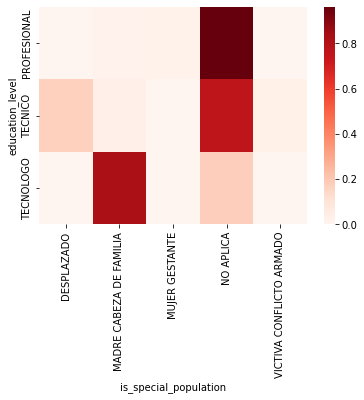

In [48]:
sns.heatmap(pd.crosstab(data_agregada['education_level'],data_agregada['is_special_population'],normalize='index'),cmap="Reds")


In [49]:
chi2_contingency(prof_esp)[1]

0.11149122308130918

## Análisis

importante relacipn entre las personas profesionales y su nivel dde estrato socioeconomico

In [50]:
prof_ESTRATO=pd.crosstab(data_agregada.drop_duplicates(subset=['promoter_name'])['education_level'],data_agregada.drop_duplicates(subset=['promoter_name'])['ESTRATO_SOCIAL'])
prof_ESTRATO

ESTRATO_SOCIAL,1.0,2.0,3.0
education_level,,,
PROFESIONAL,9,7,4
TECNICO,20,1,0
TECNOLOGO,2,0,0


<AxesSubplot:xlabel='ESTRATO_SOCIAL', ylabel='education_level'>

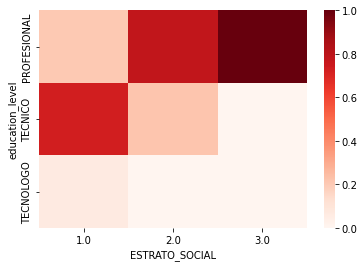

In [51]:
sns.heatmap(pd.crosstab(data_agregada['education_level'],data_agregada['ESTRATO_SOCIAL'],normalize='columns'),cmap="Reds")


In [52]:
chi2_contingency(prof_ESTRATO)[1]



0.007832063881993118

### Análisis

Debido a que los sueldos tienen una varianza relativamente baja y no se diferenica significativamente entre hombres y mujeres, 
se hace una iputaciond e los valores faltantes


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'wage (million of COP)')

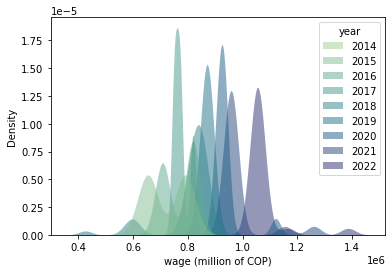

In [53]:
sns.kdeplot(x='wage',hue='year',data=data_agregada,fill=True, common_norm=False, palette="crest",
  alpha=.5, linewidth=0
  )

plt.xlabel('wage (million of COP)')

<AxesSubplot:xlabel='year', ylabel='wage'>

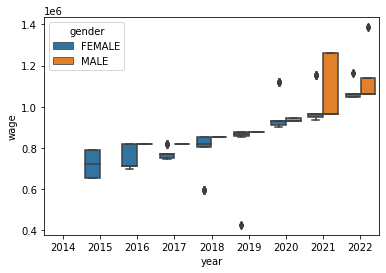

In [54]:
sns.boxplot(y='wage',x='year',hue='gender',data=data_agregada)



<AxesSubplot:xlabel='gender', ylabel='wage'>

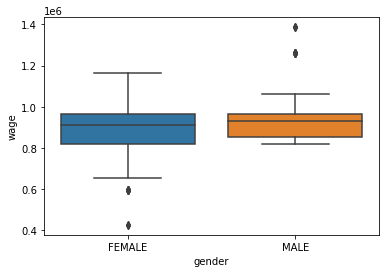

In [55]:
sns.boxplot(y='wage',x='gender',data=data_agregada)


In [56]:
imputer = KNNImputer( weights="uniform")
nueva_data=pd.DataFrame(imputer.fit_transform(data_agregada[['year','wage']]),columns=['year','wage_imputed'])

data_agregada['wage_imputed']=nueva_data['wage_imputed']


In [57]:
data_agregada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   year                     1683 non-null   int64         
 1   month                    1683 non-null   int64         
 2   promoter_name            1683 non-null   object        
 3   cedula                   1683 non-null   object        
 4   request_number           1683 non-null   int64         
 5   autorization             1683 non-null   int64         
 6   code                     1683 non-null   int64         
 7   type_id                  1680 non-null   object        
 8   gender                   1680 non-null   object        
 9   birth_date               1680 non-null   datetime64[ns]
 10  place_birth              1680 non-null   object        
 11  is_special_population    1680 non-null   object        
 12  any_disability           1680 non-

In [62]:
data_agregada.to_excel(os.path.join(ruta_insumos,'preproccess_data','data_agregada_preproccess.xlsx'))